In [1]:
import pandas as pd

# Scrape all tables from the webpage
url = "https://www.basketball-reference.com/leagues/NBA_2024_advanced.html"
tables = pd.read_html(url)

# The first table (index 0) is usually the one we want
advanced_stats_df = tables[0]

# Drop repeated header rows (Basketball Reference often embeds them inside the table)
advanced_stats_df = advanced_stats_df[advanced_stats_df['Player'] != 'Player']

# Optional: convert MP to numeric for filtering
advanced_stats_df['MP'] = pd.to_numeric(advanced_stats_df['MP'], errors='coerce')

# Filter players with > 1000 minutes
filtered_df = advanced_stats_df[advanced_stats_df['MP'] > 1000]

# Preview
filtered_df.head()


,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards
0,1.0,DeMar DeRozan,34.0,CHI,SF,79.0,79.0,2989.0,19.7,0.584,...,25.8,7.0,2.2,9.2,0.147,2.1,-0.3,1.8,2.8,CPOY-2
1,2.0,Domantas Sabonis,27.0,SAC,C,82.0,82.0,2928.0,23.2,0.637,...,22.2,8.6,4.0,12.6,0.206,4.0,2.4,6.5,6.2,"MVP-8,DPOY-10,NBA3"
2,3.0,Coby White,23.0,CHI,PG,79.0,78.0,2881.0,14.5,0.570,...,22.7,3.1,1.6,4.7,0.078,0.7,-1.3,-0.7,0.9,NaN
3,4.0,Mikal Bridges,27.0,BRK,SF,82.0,82.0,2854.0,14.9,0.560,...,24.3,2.1,2.1,4.2,0.070,0.7,-1.0,-0.4,1.2,NaN
4,5.0,Paolo Banchero,21.0,ORL,PF,80.0,80.0,2799.0,17.3,0.546,...,29.7,1.3,4.0,5.3,0.090,1.3,0.0,1.3,2.3,AS


In [2]:
# Select core advanced metrics for EDA and modeling
selected_cols = [
    'Player', 'Team', 'MP', 'PER', 'TS%', 'USG%', 'BPM', 'VORP'
]

nba_stats_df = filtered_df[selected_cols].copy()

# Preview the cleaned dataset
nba_stats_df.head()


,Player,Team,MP,PER,TS%,USG%,BPM,VORP
0,DeMar DeRozan,CHI,2989.0,19.7,0.584,25.8,1.8,2.8
1,Domantas Sabonis,SAC,2928.0,23.2,0.637,22.2,6.5,6.2
2,Coby White,CHI,2881.0,14.5,0.570,22.7,-0.7,0.9
3,Mikal Bridges,BRK,2854.0,14.9,0.560,24.3,-0.4,1.2
4,Paolo Banchero,ORL,2799.0,17.3,0.546,29.7,1.3,2.3


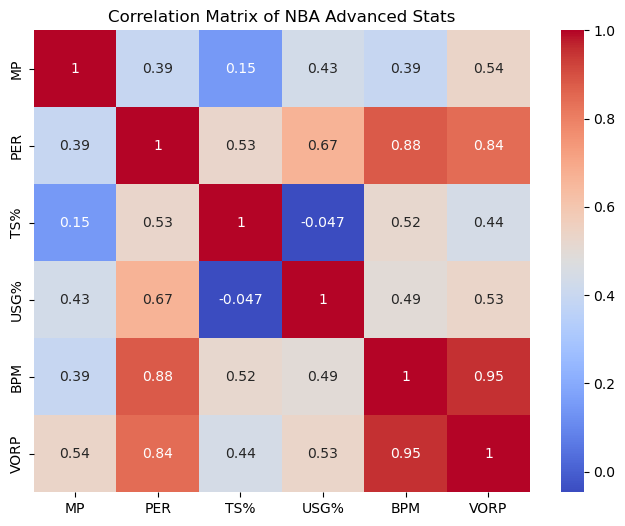

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns for correlation
numeric_df = nba_stats_df.drop(columns=['Player', 'Team'])

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of NBA Advanced Stats")
plt.show()


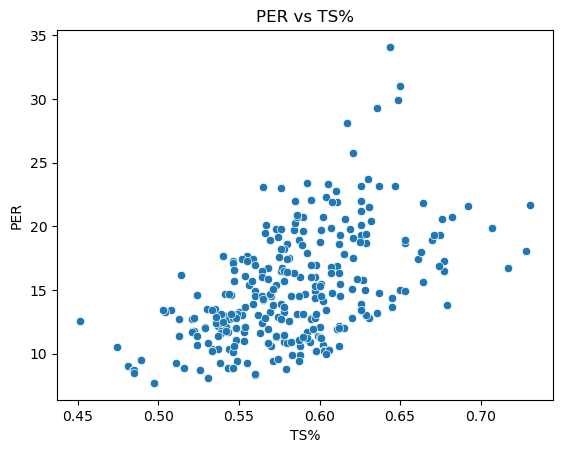

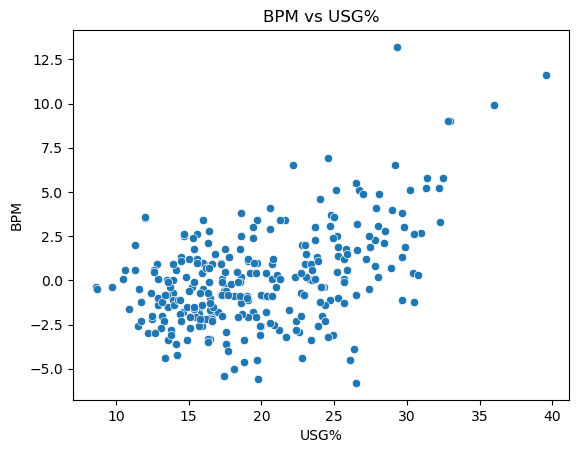

In [4]:
# PER vs TS%
sns.scatterplot(data=nba_stats_df, x='TS%', y='PER')
plt.title("PER vs TS%")
plt.show()

# BPM vs USG%
sns.scatterplot(data=nba_stats_df, x='USG%', y='BPM')
plt.title("BPM vs USG%")
plt.show()


In [5]:
# Top 10 by PER
nba_stats_df.sort_values(by='PER', ascending=False).head(10)

# Top 10 by BPM
nba_stats_df.sort_values(by='BPM', ascending=False).head(10)

# Top 10 by VORP
nba_stats_df.sort_values(by='VORP', ascending=False).head(10)


,Player,Team,MP,PER,TS%,USG%,BPM,VORP
8,Nikola Jokić,DEN,2737.0,31.0,0.650,29.3,13.2,10.6
20,Luka Dončić,DAL,2624.0,28.1,0.617,36.0,9.9,8.0
27,Giannis Antetokounmpo,MIL,2567.0,29.9,0.649,33.0,9.0,7.2
29,Shai Gilgeous-Alexander,OKC,2553.0,29.3,0.636,32.8,9.0,7.1
1,Domantas Sabonis,SAC,2928.0,23.2,0.637,22.2,6.5,6.2
9,Jalen Brunson,NYK,2726.0,23.4,0.592,32.5,5.8,5.4
31,LeBron James,LAL,2504.0,23.7,0.630,29.2,6.5,5.4
67,Tyrese Haliburton,IND,2224.0,23.3,0.605,24.6,6.9,5.0
11,Anthony Davis,LAL,2700.0,25.8,0.621,26.7,5.1,4.9
17,Jayson Tatum,BOS,2645.0,22.3,0.604,30.2,5.1,4.7


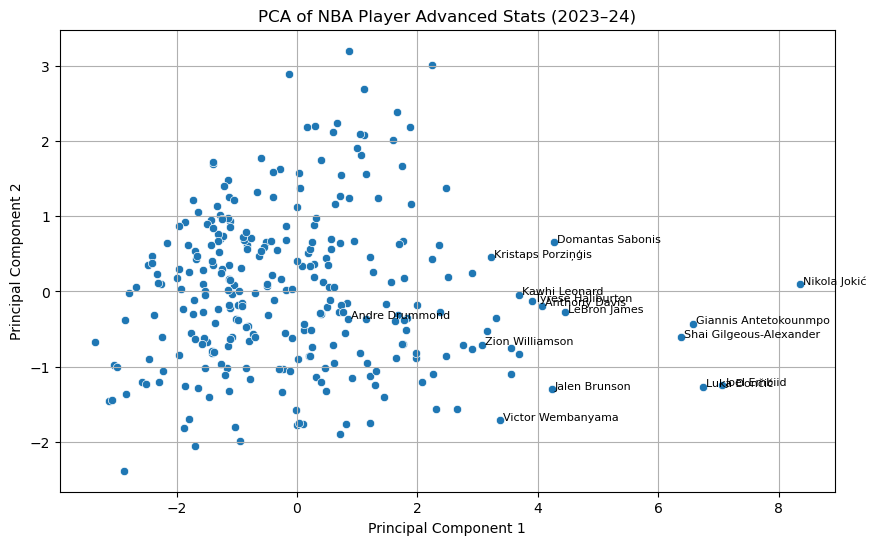

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select just the numeric columns (exclude Player, Team, MP if you want pure stat-based PCA)
features = ['PER', 'TS%', 'USG%', 'BPM', 'VORP']
X = nba_stats_df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add PCA components to the dataframe
nba_stats_df['PC1'] = pca_components[:, 0]
nba_stats_df['PC2'] = pca_components[:, 1]


# Scatter plot of PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=nba_stats_df, x='PC1', y='PC2')

for i, row in nba_stats_df.iterrows():
    if row['PER'] > nba_stats_df['PER'].quantile(0.95):  # label top 5% efficient players
        plt.text(row['PC1'] + 0.05, row['PC2'], row['Player'], fontsize=8)

plt.title("PCA of NBA Player Advanced Stats (2023–24)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()



In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define features and target
X = nba_stats_df[['TS%', 'USG%', 'BPM', 'VORP']]
y = nba_stats_df['PER']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict + evaluate
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Show coefficients
coeffs = pd.Series(reg.coef_, index=X.columns)

print("R² Score:", r2)
print("Feature Importance (Coefficients):")
print(coeffs)


R² Score: 0.8042478400102984
Feature Importance (Coefficients):
TS%     28.402804
USG%     0.319185
BPM      0.857544
VORP    -0.056846
dtype: float64
